In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import cv2

from MagicPoint.dataset.art_dataset import *
from MagicPoint.dataset.dataset_pipeline import parse_primitives, photometric_augmentation, homographic_augmentation
from common.utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [3]:
config = load_config('../configs/art_config_notebooks.yaml')
data_config = config['data']
experiment_config = config['experiment']


In [4]:
set_seed(experiment_config['seed'])

data_config['augmentation']['photometric']['enable'] = False
data_config['augmentation']['homographic']['enable'] = False

trainDataset = ArtificialDataset(TRAINING, data_config)


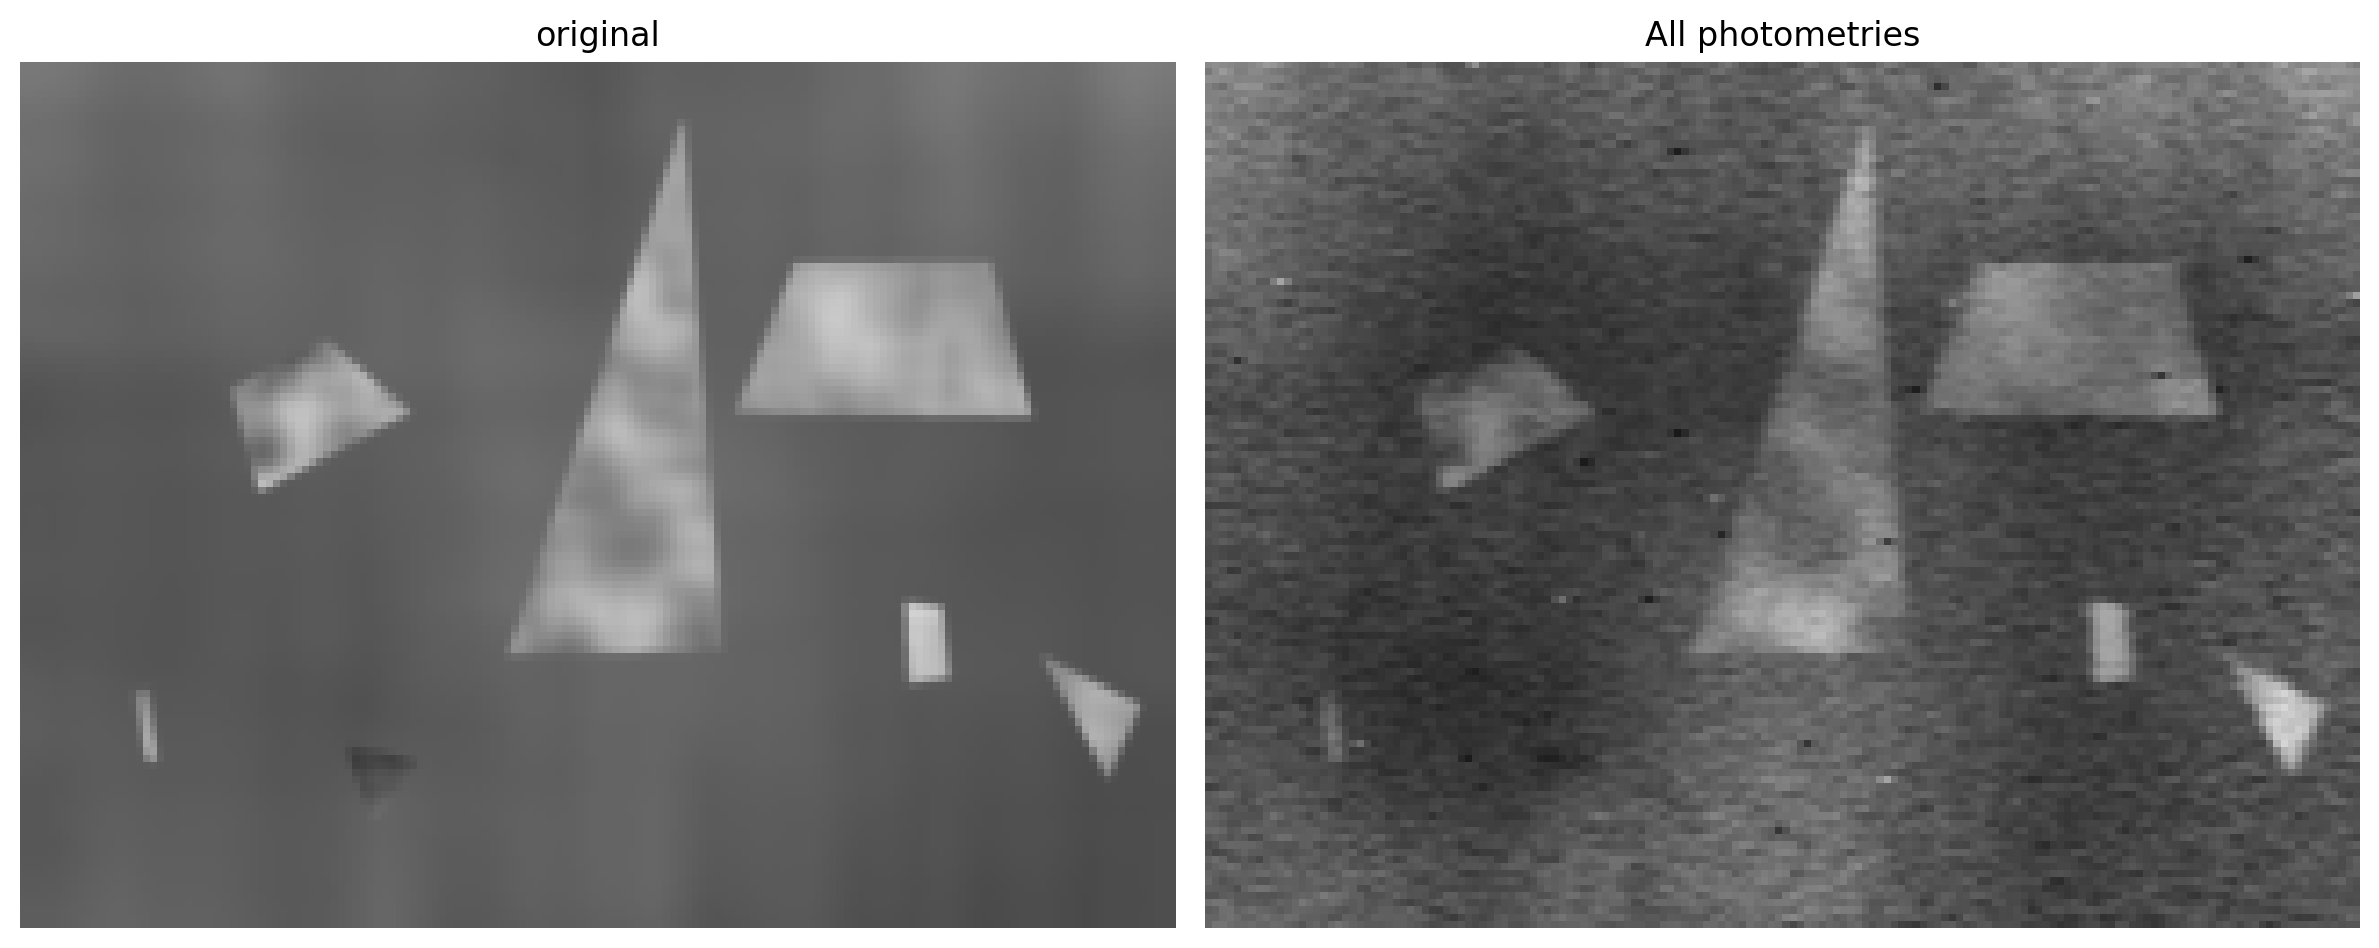

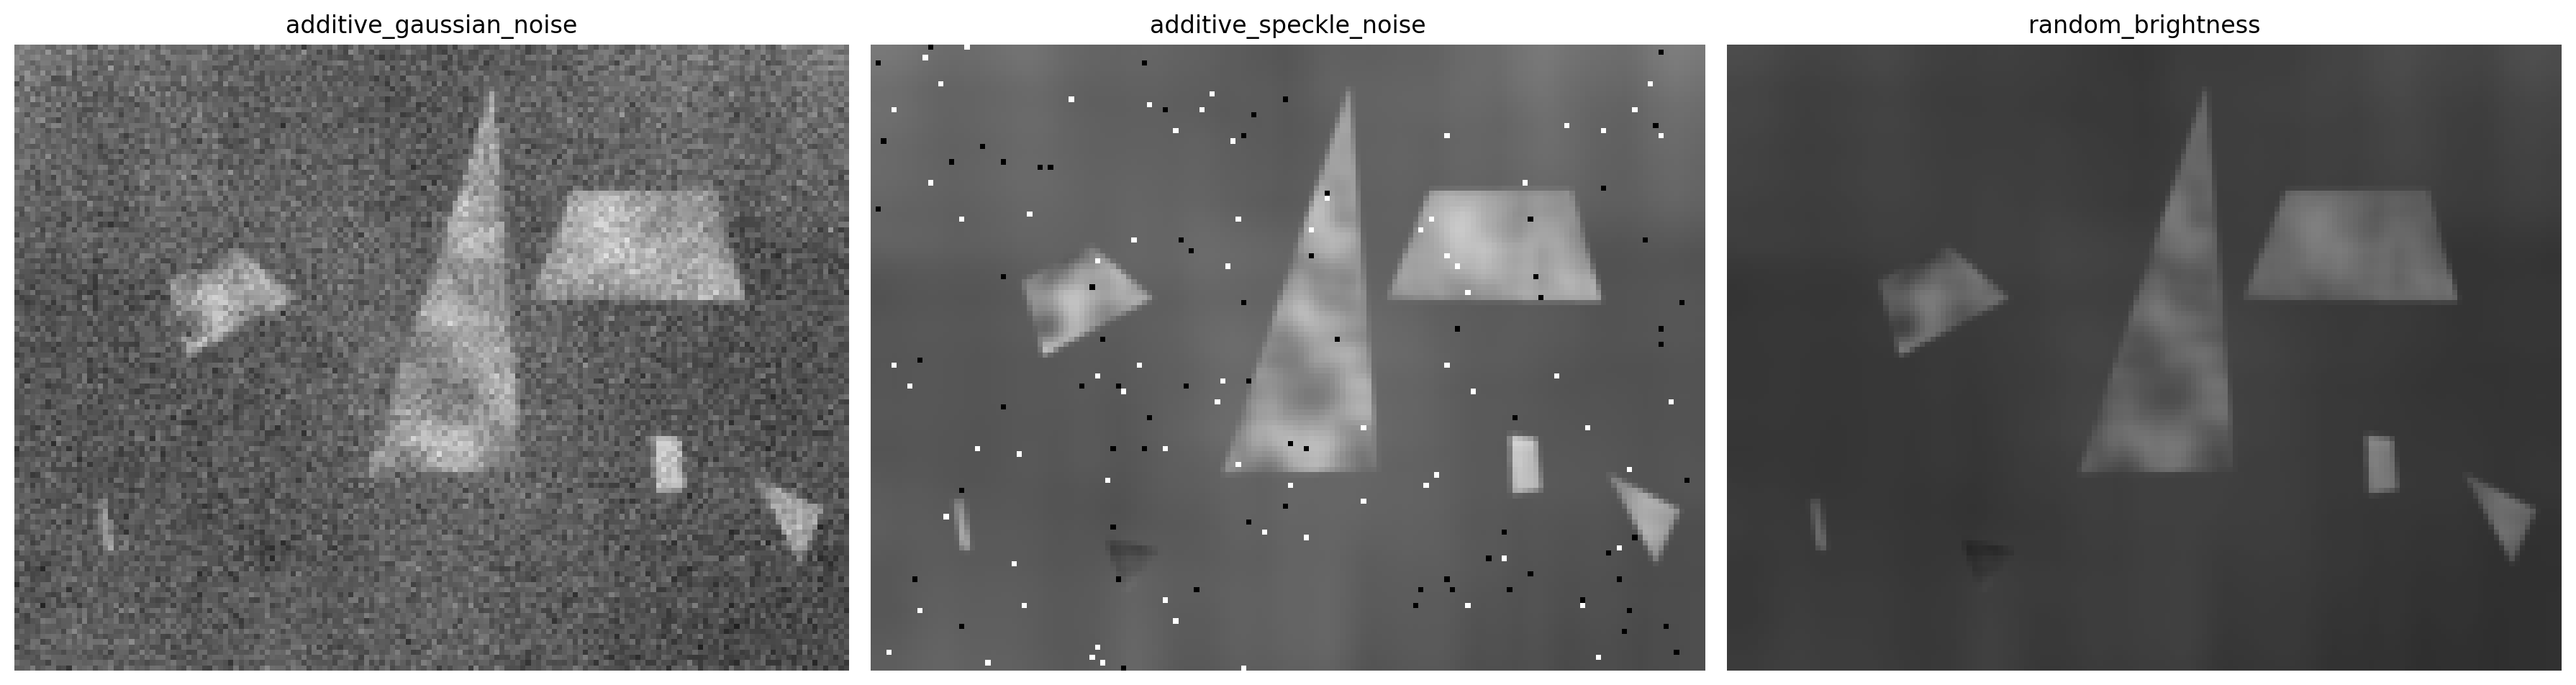

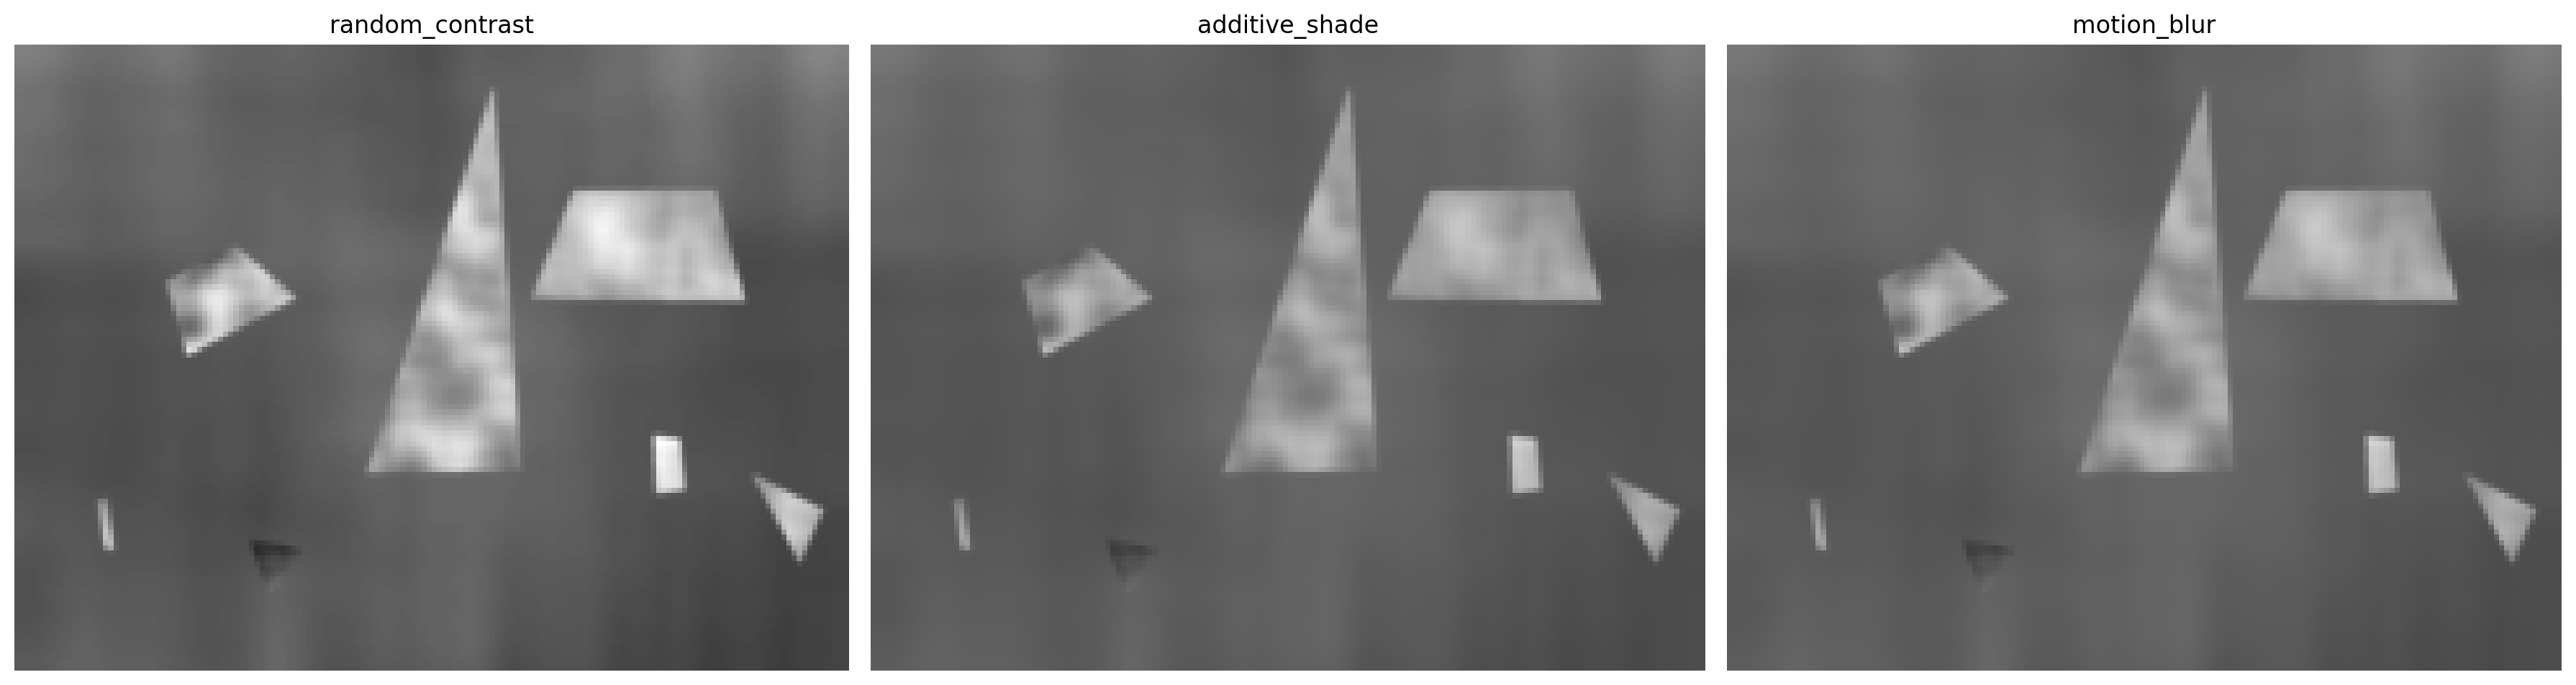

In [5]:
# Photometric augmentation visualization

rows = 1

for _ in range(rows):
    index = np.random.randint(0, trainDataset.__len__())
    item = trainDataset.__getitem__(index)
    
    grayscale_image = to255scale(rgb2grayscale(item[IMAGE]))
    all_grayscale = photometric_augmentation(grayscale_image, data_config)
    
    frames = [grayscale2rgb(grayscale_image).transpose((1, 2, 0)), 
              grayscale2rgb(all_grayscale).transpose((1, 2, 0))]
    
    plot_images(frames, titles=['original', 'All photometries'], dpi=200)
    
    frames = []
    
    primitives = parse_primitives(data_config['primitives'], photometries.augmentations)
    prim_configs = [data_config['augmentation']['photometric']['params'].get(p, {}) for p in primitives]
    
    for p, c in zip(primitives, prim_configs):
        photometried = getattr(photometries, p)(grayscale_image, c)
        frames.append(grayscale2rgb(photometried).transpose((1, 2, 0)))
        
    plot_images(frames[:3], titles=primitives[:3], dpi=200)
    plot_images(frames[3:], titles=primitives[3:], dpi=200)


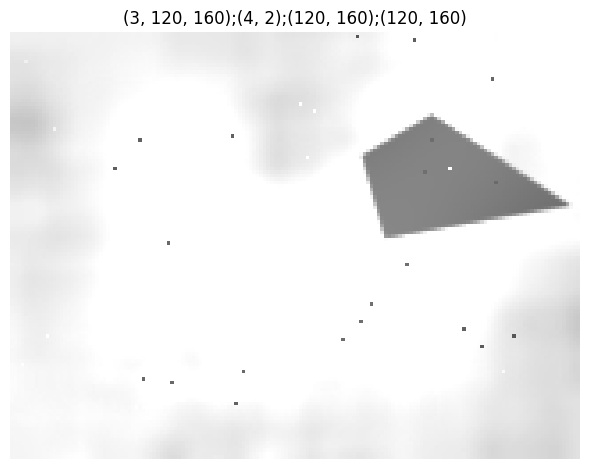

In [6]:
data_config['augmentation']['photometric']['enable'] = True
data_config['augmentation']['homographic']['enable'] = False

trainPhoto = ArtificialDataset(TRAINING, data_config)

index = np.random.randint(0, trainPhoto.__len__())
item = trainPhoto.__getitem__(index)

title = "{};{};{};{}".format(item[IMAGE].shape, item[POINTS].shape, item[KEYPOINT_MAP].shape, item[MASK].shape)

plot_images([to255scale(item[IMAGE]).transpose((1, 2, 0))], [title])


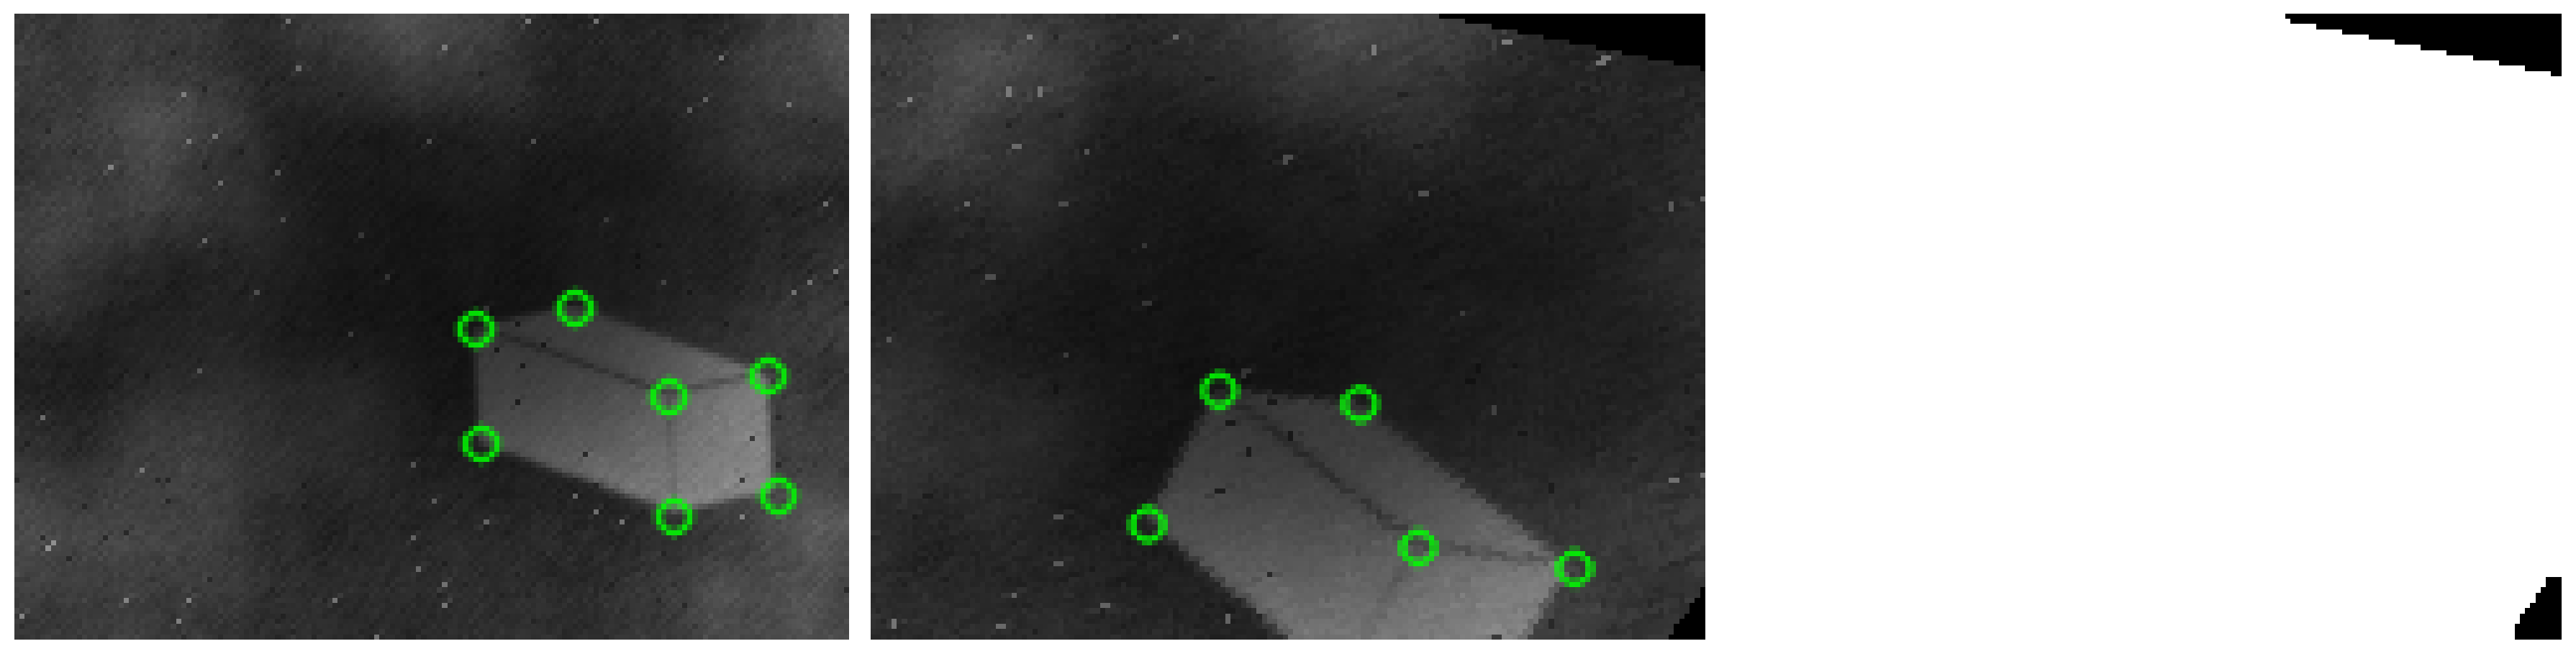

In [7]:
# Homographic augmentation visualization

for _ in range(rows):
    index = np.random.randint(low=0, high=trainDataset.__len__())
    item = trainDataset.__getitem__(index)
    
    frames = []
    
    image = to255scale(item[IMAGE]).transpose((1, 2, 0))
    frame_keypoints = [cv2.KeyPoint(c[1], c[0], 1) for c in np.stack(np.where(item[KEYPOINT_MAP])).T]
    frames.append(cv2.drawKeypoints(image, frame_keypoints, None, color=(0, 255, 0)))
    
    warped_image, warped_points, warped_mask = homographic_augmentation(to255scale(rgb2grayscale(item[IMAGE])), 
                                                                        item[POINTS], data_config)

    
    wp_image = grayscale2rgb(warped_image).transpose((1, 2, 0))
    wp_frame = [cv2.KeyPoint(c[1], c[0], 1) for c in warped_points]
    wp_mask = grayscale2rgb(to255scale(warped_mask)).transpose((1, 2, 0))
    
    frames.append(cv2.drawKeypoints(wp_image, wp_frame, None, color=(0, 255, 0)))
    frames.append(wp_mask)
    
    plot_images(frames, dpi=200)


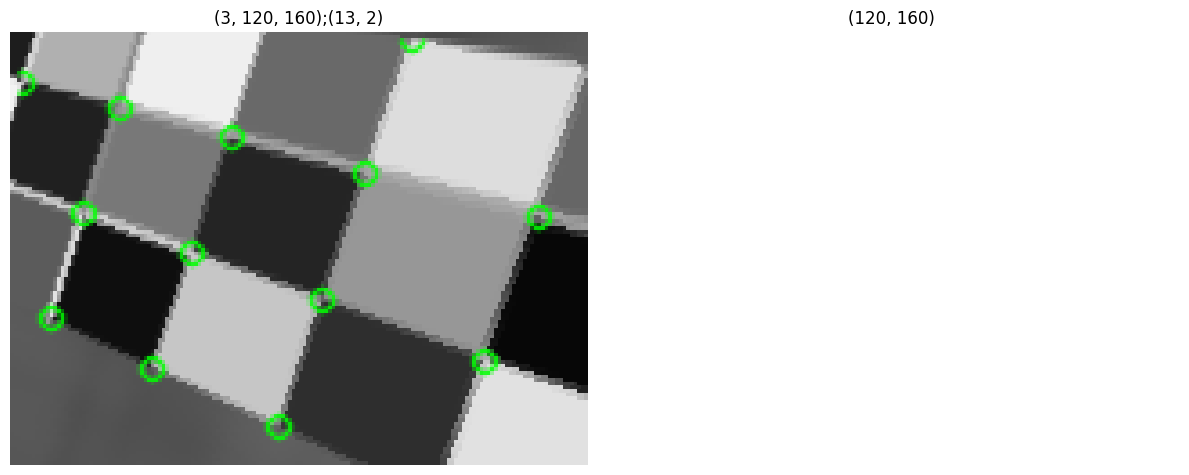

In [106]:
data_config['augmentation']['photometric']['enable'] = False
data_config['augmentation']['homographic']['enable'] = True

trainHomo = ArtificialDataset(TRAINING, data_config)

index = np.random.randint(0, trainHomo.__len__())
item = trainHomo.__getitem__(index)

frames = []
titles = []

image = to255scale(item[IMAGE]).transpose((1, 2, 0))
frame_keypoints = [cv2.KeyPoint(c[1], c[0], 1) for c in np.stack(np.where(item[KEYPOINT_MAP])).T]
mask = grayscale2rgb(to255scale(item[MASK])).transpose((1, 2, 0))

frames.append(cv2.drawKeypoints(image, frame_keypoints, None, color=(0, 255, 0)))
frames.append(mask)

image_title = "{};{}".format(item[IMAGE].shape, item[POINTS].shape)
mask_title = "{}".format(item[MASK].shape)

titles.append(image_title)
titles.append(mask_title)

plot_images(frames, titles)